In [ ]:
import numpy as np
import basix
import matplotlib.pyplot as plt
from basix import CellType, ElementFamily, LagrangeVariant, LatticeType
import jax_pn
import scipy.sparse as sp
from matplotlib.lines import Line2D

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from dataclasses import dataclass
energy_groups = np.array([1.42907e+07, 1.00000e+06, 3.00000e+02, 1.00000e+01, 1.00000e-01])
from breeding_blanket_data import get_breeding_blanket_data
data_dict, aux_data_dict = get_breeding_blanket_data()


Solving system with shape: (24096, 24096) and 24096 equations.


# Setup 

The blanket has 8 regions:

1. Plasma: source of the neutrons (20 cm)
2. Tungstenarmor: the first layer on the wall (0.2 cm)
3. FirstWall: the first wall itself  (2.5 cm)
4. BreedingZone: the helium-cooled-pebble-bed breeding area, variable size but ~ 50 cm
5. BackSupportingStructure: the structural support of the blanket (38.5 cm)
6. VVWallFront: the front of the vacuum vessel (6 cm)
7. VVShield: the vacuum vessel shield, shielding neutrons (variable size, ~20cm)
8. VVWallBack: the back of the vacuum vessel (6 cm)


Below is a function that creates these regions using the proper data based on the sizes given

In [63]:
# Define zero sources for in the blanket, and a unit source in the plasma
zero_source = np.array([0.0, 0.0, 0.0, 0.0])
one_source  = np.array([1, 0.0, 0.0, 0.0])
# Complete regions list with all 8 materials using actual HDF5 data (in data_dict)

def create_regions(sizes, data_dict):
    regions = [
        (0.2,   *data_dict['Plasma'],                    one_source),
        (sizes[0], *data_dict['TungstenArmor'],            zero_source),
        (sizes[1], *data_dict['FirstWall'],                zero_source),
        (sizes[2], *data_dict['BreedingZone'],             zero_source),
        (sizes[3], *data_dict['BackSupportingStructure'], zero_source), 
        (sizes[4], *data_dict['VVWallFront'],             zero_source), 
        (sizes[5], *data_dict['VVShield'],                 zero_source),
        (sizes[6], *data_dict['VVWallBack'],              zero_source)  
    ]
    return regions

base_sizes = [0.002, 0.025, 0.6, 0.385, 0.06, 0.2, 0.06]

base_regions = create_regions(base_sizes, data_dict)

Then, we have to setup and run the simulation itself:

In [ ]:
def run_simulation(regions, elements_per_region, N_max, L_max):
    lagrange    = basix.create_element(ElementFamily.P, CellType.interval, degree= 10, lagrange_variant= LagrangeVariant.gll_warped)
    
    ad_pn = jax_pn.ADPN.ADPN_Problem.from_regions_per_region(regions = regions , elements_per_region= elements_per_region, N_max =  N_max, element = lagrange, L_scat=L_max)
    solution = jnp.array(ad_pn.Solve_Multigroup_System("reflective", "vacuum", 4))
    return solution, ad_pn
# Some parameters describing the implementation of the simulation, don't have to touch this
L_max = 5
N_max = 5
elements_per_region = [5, 1, 1, 5, 5, 1, 5, 2]
solution, ad_pn = run_simulation(base_regions, elements_per_region, N_max, L_max)

Solving system with shape: (6048, 6048) and 6048 equations.


Plotting the result can be done using  the function plot_simulation

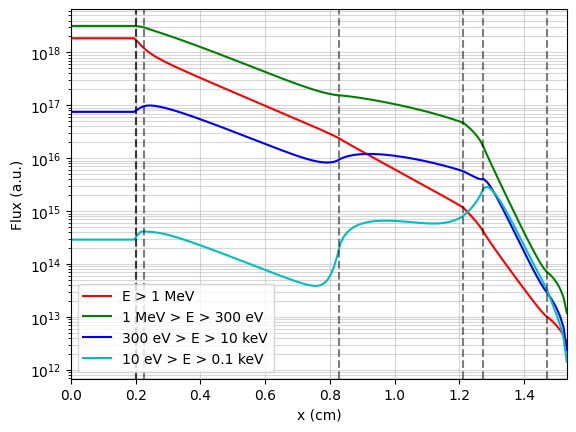

In [80]:
def plot_simulation(regions, ad_pn, solution):
    total_size = sum([r[0] for r in regions])
    x_interp = np.linspace(0,total_size, 150)
    ad_f     = np.array([ad_pn.interpolate_solution(x_interp, k=0, energy_group = eg ) for eg in range(4)]).T

    colors   = ['r', 'g', 'b', 'c']
    labels   = ['E > 1 MeV', '1 MeV > E > 300 eV', '300 eV > E > 10 keV', '10 eV > E > 0.1 keV']
    
    for i in range(4):    
        plt.semilogy(x_interp, ad_f[:, i] * 1.6e18, color=colors[i], linestyle='-', label = labels[i])

    size_regions = [regions[i][0] for i in range(len(regions))]
    region_sizes = np.cumsum(size_regions)
    for i in range(len(region_sizes)-1):
        plt.axvline(region_sizes[i], color='k', linestyle='--', alpha=0.5)
    plt.xlim(0.0, total_size)
    plt.grid(which='both', alpha=0.5)
    plt.xlabel('x (cm)')
    plt.ylabel('Flux (a.u.)')
    _ = plt.legend()

plot_simulation(base_regions, ad_pn, solution)

We can also compute the tritium breeding ratio (ratio of neutron source to tritium produced) and the coiil flux.

For a coil, it is desired to have a coil flux less than 10^13.

Tritium breeding ratio needs to be > 1.15

In [102]:

def tritium_breeding(ad_pn, solution):        
    tritium_xs          = jnp.array(aux_data_dict['BreedingZone']['nt'])

    parameters_eg = {
        'sigma_t_i'       : ad_pn.jax_sigma_t,
        'sigma_s_k_i_gg'  : ad_pn.jax_sigma_s,
        'h_i'             : ad_pn.jax_h_i,
        'q_i_k_j'         : ad_pn.jax_q_i_k_j
    }
    #elements_per_region_i = jnp.array(elements_per_region)
    bz_elements_offset  = int(sum(elements_per_region[:3]))
    bz_elements_total   = int(elements_per_region[3])   
    matrix_settings     = ad_pn.matrix_settings
    global_settings     = ad_pn.global_settings
    Ii         = jnp.sum(matrix_settings.mass_matrix, axis=0)            
    sol        = solution.reshape((global_settings.n_energy_groups, global_settings.n_moments, -1))                    
    def element_sum(i):
        
        return jnp.sum(sol[:, 0, matrix_settings.elem_dof_matrix[i]] * Ii[None, :] , axis = 1) * parameters_eg["h_i"][i]    
    elem_sums = jnp.sum(jax.vmap(element_sum)(jnp.arange(bz_elements_offset, bz_elements_total + bz_elements_offset)), axis=0)  * tritium_xs * 1e2
    return jnp.sum(elem_sums) 

def coil_flux(ad_pn, solution):    
    return solution[ad_pn.global_settings.right_dof] * 1.6e18



def tritium_breeding_ratio(ad_pn, solution):
    fudge_factor  = 0.8 # accounts for non-ideal effects in breeding blanket: 3D effects, not straight at the blanket, etc.
    return tritium_breeding(ad_pn, solution) / 0.2 *  (fudge_factor)

tritium_breeding_ratio(ad_pn, solution)

coil_flux(ad_pn, solution)

Array(3.32942347e+12, dtype=float64)

### Chaining functions

We can chain these functions:

Solving system with shape: (6048, 6048) and 6048 equations.
Tritium breeding ratio: 1.3936


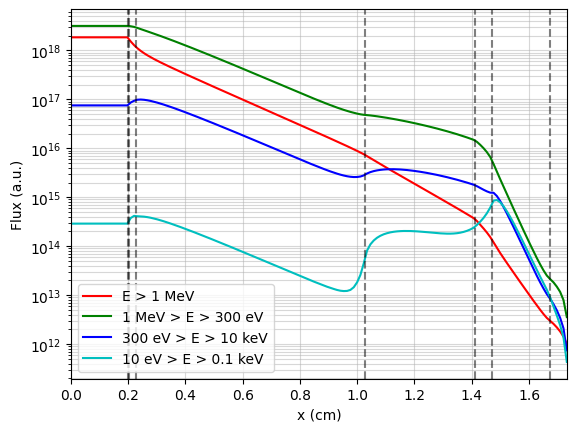

In [103]:
def plot_solution(breeding_size, shield_size):
    sizes = [0.002, 0.025, breeding_size, 0.385, 0.06, shield_size, 0.06]
    regions = create_regions(sizes, data_dict)
    solution, ad_pn = run_simulation(regions, elements_per_region, N_max, L_max)
    plot_simulation(regions, ad_pn, solution)
    tbr = tritium_breeding_ratio(ad_pn, solution)
    print(f"Tritium breeding ratio: {tbr:.4f}")
    return tbr


_ = plot_solution(0.8, 0.2)

In [104]:
def compute_tbr_coil_flux(breeding_size, shield_size):
    
    sizes = [0.002, 0.025, breeding_size, 0.385, 0.06, shield_size, 0.06]
    regions = create_regions(sizes, data_dict)
    solution, ad_pn = run_simulation(regions, elements_per_region, N_max, L_max)
    
    tbr = tritium_breeding_ratio(ad_pn, solution)
    coil_f = coil_flux(ad_pn, solution)
    
    return tbr, coil_f


breeding_sizes = np.linspace(0.1, 1.0, 10)
tbr_i = np.array([compute_tbr_coil_flux(i, 0.2) for i in breeding_sizes])

Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.
Solving system with shape: (6048, 6048) and 6048 equations.


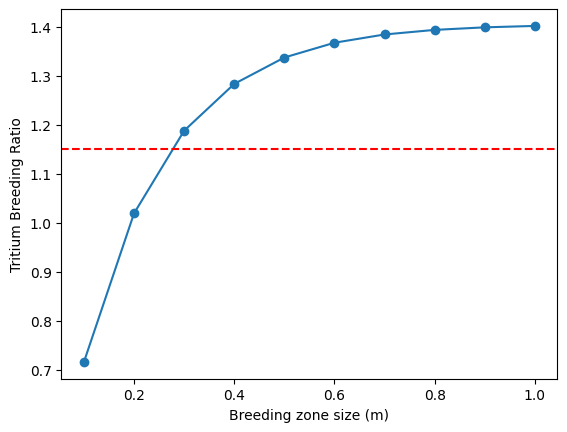

In [106]:
plt.plot(breeding_sizes, tbr_i[:,0], marker='o')
plt.xlabel('Breeding zone size (m)')
plt.ylabel('Tritium Breeding Ratio')
plt.axhline(1.15, color = 'r', linestyle = '--')

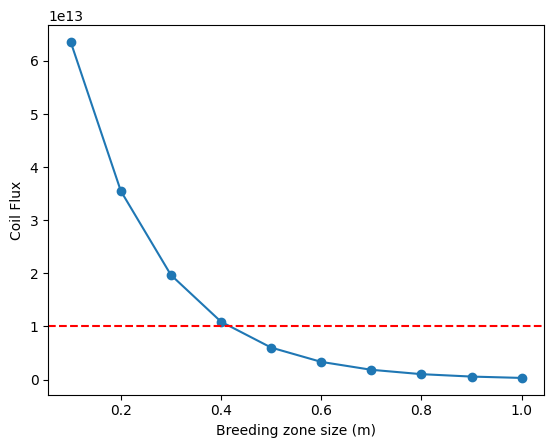

In [101]:
plt.plot(breeding_sizes, tbr_i[:,1], marker='o')
plt.xlabel('Breeding zone size (m)')
plt.ylabel('Coil Flux')
plt.axhline(1e13, color = 'r', linestyle = '--')

We can also commpute the total size for a given blanket specification:

In [116]:
def compute_total_size(regions):
    total_size = sum([r[0] for r in regions]) - 0.2
    return total_size

print(compute_total_size(base_regions))

1.332
